In [ ]:
!pip install sklearn
!pip install transformers
!pip install seaborn

In [80]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline
from transformers import Trainer, TrainingArguments

from IPython.display import clear_output
import logging
logging.basicConfig(level=logging.ERROR)

from cf_matrix import make_confusion_matrix

import warnings
warnings.filterwarnings("ignore")

In [101]:
def no_emoji(X):
    for i in range(len(X)):
        s = ''
        count = 0
        for j in range(len(X[i])):
            if X[i][j] == "[":
                count += 1
            elif count == 0:
                s += X[i][j]
            if X[i][j] == "]" and count > 0:
                count -= 1
        X[i] = s
    return X

def split(df, need_emoji = True, random_state = 0):
    X = list(df['review'])
    y = list(df['label'])
    # 60% train, 20% development, 20% test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = random_state)
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state = random_state)
    if not need_emoji:
        X_train = no_emoji(X_train)
        X_val = no_emoji(X_val)
        X_test = no_emoji(X_test)
    return X_train, X_val, X_test, y_train, y_val, y_test

def performance(X_test, y_test, classifier, threshold = 0.5):
    #convert = {'positive (stars 4 and 5)': 1, 'negative (stars 1, 2 and 3)': 0}
    convert = {'LABEL_1': 1, 'LABEL_0': 0}
    y_pred = []
    for review in X_test:
        prediction = classifier(review)[0]
        label = convert[prediction['label']]
        if label == 1 and prediction['score'] < threshold:
            label = 0
        y_pred.append(label)
        clear_output(wait = True)
        print("{}/{}".format(len(y_pred), len(y_test)))
    cf_matrix = confusion_matrix(y_test, y_pred)
    labels = ['TN', 'FP', 'FN', 'TP']
    categories = ['Negative', 'Positive']
    make_confusion_matrix(cf_matrix, group_names = labels, categories = categories, cmap = 'binary')

In [104]:
df = pd.read_csv('Data/processed_data.csv')
df = df.dropna().drop("Unnamed: 0", axis = 1)
df.head()

,label,review,has_emoji,emojis
0,1,﻿更博了，爆照了，帅的呀，就是越来越爱你！生快傻缺[爱你][爱你][爱你],1,{'[爱你]': 3}
1,1,@张晓鹏jonathan 土耳其的事要认真对待[哈哈]，否则直接开除。@丁丁看世界 很是细心...,1,{'[哈哈]': 1}
2,1,姑娘都羡慕你呢…还有招财猫高兴……,0,{}
3,1,美~~~~~[爱你],1,{'[爱你]': 1}
4,1,梦想有多大，舞台就有多大![鼓掌],1,{'[鼓掌]': 1}


In [105]:
df_emoji = df[df['has_emoji'] == 1]
# data with emoji
X_train_1, X_val_1, X_test_1, y_train_1, y_val_1, y_test_1 = split(df_emoji)
# same data with emoji removed
X_train_2, X_val_2, X_test_2, y_train_2, y_val_2, y_test_2 = split(df_emoji, need_emoji = False)

In [106]:
class WeiboSentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [107]:
tokenizer = AutoTokenizer.from_pretrained('uer/chinese_roberta_L-12_H-768')

loading configuration file https://huggingface.co/uer/chinese_roberta_L-12_H-768/resolve/main/config.json from cache at /home/zl2042/.cache/huggingface/transformers/0581d850743cad42501488567cceb8dc9ce50d9f05ad632d273b4389b2f52f68.042085124aedc502028136283b7bf9a169a238009bd6c309f049b249216061a2
Model config BertConfig {
  "_name_or_path": "uer/chinese_roberta_L-12_H-768",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.17.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 21128
}

loading file https://huggingfac

In [108]:
# data encodings
X_train_encodings = tokenizer(X_train_1, truncation=True, padding=True)
X_val_encodings = tokenizer(X_val_1, truncation=True, padding=True)
X_test_encodings = tokenizer(X_test_1, truncation=True, padding=True)

In [109]:
# dataset
train_dataset = WeiboSentDataset(X_train_encodings, y_train_1)
val_dataset = WeiboSentDataset(X_val_encodings, y_val_1)
test_dataset = WeiboSentDataset(X_test_encodings, y_test_1)

In [110]:
# training arguments
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=1,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    learning_rate=5e-5,              # learning rate or step size
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=100,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [111]:
# uer chinese roberta model
model = AutoModelForSequenceClassification.from_pretrained('uer/chinese_roberta_L-12_H-768')

loading configuration file https://huggingface.co/uer/chinese_roberta_L-12_H-768/resolve/main/config.json from cache at /home/zl2042/.cache/huggingface/transformers/0581d850743cad42501488567cceb8dc9ce50d9f05ad632d273b4389b2f52f68.042085124aedc502028136283b7bf9a169a238009bd6c309f049b249216061a2
Model config BertConfig {
  "_name_or_path": "uer/chinese_roberta_L-12_H-768",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.17.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 21128
}

loading weights file https://hu

In [112]:
# define trainer
trainer = Trainer(
    model=model,                         # the instantiated Transformers model to be trained
    args=training_args,                  # training arguments
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset             # evaluation dataset
)

In [113]:
# train model
trainer.train()

***** Running training *****
  Num examples = 57276
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 3580


Step,Training Loss
100,0.549600
200,0.197000
300,0.183100
400,0.216900
500,0.172500
600,0.204100
700,0.200300
800,0.193800
900,0.201400
1000,0.166800


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1500
Configuration saved in ./results/checkpoint-1500/config.json
Model weights saved in ./results/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-2000
Configuration saved in ./results/checkpoint-2000/config.json
Model weights saved in ./results/checkpoint-2000/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-2500
Configuration saved in ./results/checkpoint-2500/config.json
Model weights saved in ./results/checkpoint-2500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-3000
Configuration saved in ./results/checkpoint-3

TrainOutput(global_step=3580, training_loss=0.17831013162708814, metrics={'train_runtime': 749.9252, 'train_samples_per_second': 76.376, 'train_steps_per_second': 4.774, 'total_flos': 6063299715235680.0, 'train_loss': 0.17831013162708814, 'epoch': 1.0})

In [114]:
# save model
model.save_pretrained("./trained_model/roberta_weibo_emoji")

Configuration saved in ./trained_model/roberta_weibo_emoji/config.json
Model weights saved in ./trained_model/roberta_weibo_emoji/pytorch_model.bin


In [115]:
# classifier
classifier = pipeline('sentiment-analysis', model = model, tokenizer = tokenizer, device = 0)

19093/19093


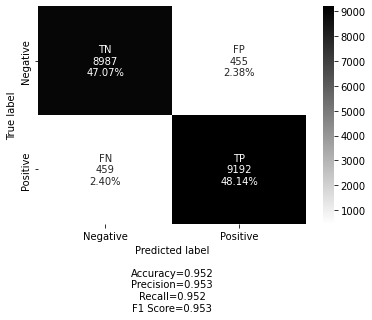

In [116]:
# performance on data with emoji
performance(X_test_1, y_test_1, classifier)

19093/19093


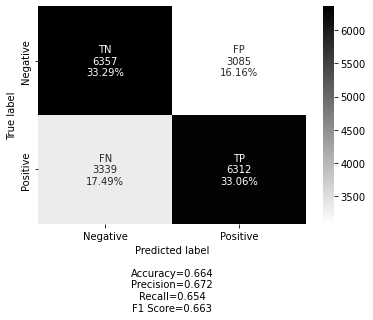

In [117]:
# performance on data with emoji removed
performance(X_test_2, y_test_2, classifier)

Around 5% of data has length less than or equal to 1 when emoji is removed, so they may be ambiguous when classifying. We set a threshold of 4 to filter out short texts, and re-assess.

In [129]:
# remove texts with length shorter than 4
X_test_1_filtered = []
y_test_1_filtered = []
X_test_2_filtered = []
y_test_2_filtered = []

for i in range(len(X_test_2)):
    if len(X_test_2[i]) >= 10:
        X_test_1_filtered.append(X_test_1[i])
        y_test_1_filtered.append(y_test_1[i])
        X_test_2_filtered.append(X_test_2[i])
        y_test_2_filtered.append(y_test_2[i])

16926/16926


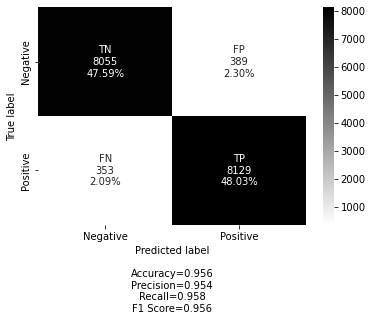

In [127]:
# filtered, performance on data with emoji
performance(X_test_1_filtered, y_test_1_filtered, classifier)

16926/16926


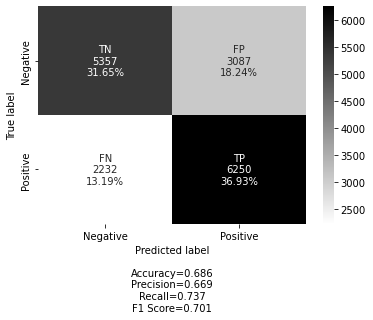

In [128]:
# filtered, performance on data with emoji removed
performance(X_test_2_filtered, y_test_2_filtered, classifier)

14011/14011


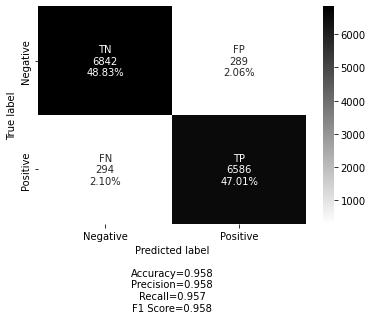

In [130]:
# filtered, performance on data with emoji
performance(X_test_1_filtered, y_test_1_filtered, classifier)

14011/14011


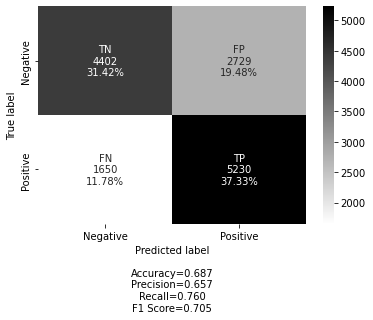

In [132]:
# filtered, performance on data with emoji removed
performance(X_test_2_filtered, y_test_2_filtered, classifier)